# Ordinary Differential Equations

**Learning Objectives:** Understand the numerical solution of ODEs and use `scipy.integrate.odeint` to solve and explore ODEs numerically.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Overview of ODEs

Many of the equations of Physics, Chemistry, Statistics, Data Science, etc. are *Ordinary Differential Equation* or *ODEs*. An ODE is a differential equation with the form:

$$ \frac{d\vec{y}}{dt} = \vec{f}\left(\vec{y}(t), t\right) $$

The goal is usually to solve for the $N$ dimensional state vector $\vec{y}(t)$ at each time $t$ given some initial condition:

$$ \vec{y}(0) = \vec{y}_0 $$

In this case we are using $t$ as the independent variable, which is common when studying differential equations that depend on time. But any independent variable may be used, such as $x$. Solving an ODE numerically usually involves picking a set of $M$ discrete times at which we wish to know the solution:

In [2]:
tmax = 10.0 # The max time
M = 100     # Use 100 times between [0,tmax]
t = np.linspace(0,tmax,M)
t

array([  0.        ,   0.1010101 ,   0.2020202 ,   0.3030303 ,
         0.4040404 ,   0.50505051,   0.60606061,   0.70707071,
         0.80808081,   0.90909091,   1.01010101,   1.11111111,
         1.21212121,   1.31313131,   1.41414141,   1.51515152,
         1.61616162,   1.71717172,   1.81818182,   1.91919192,
         2.02020202,   2.12121212,   2.22222222,   2.32323232,
         2.42424242,   2.52525253,   2.62626263,   2.72727273,
         2.82828283,   2.92929293,   3.03030303,   3.13131313,
         3.23232323,   3.33333333,   3.43434343,   3.53535354,
         3.63636364,   3.73737374,   3.83838384,   3.93939394,
         4.04040404,   4.14141414,   4.24242424,   4.34343434,
         4.44444444,   4.54545455,   4.64646465,   4.74747475,
         4.84848485,   4.94949495,   5.05050505,   5.15151515,
         5.25252525,   5.35353535,   5.45454545,   5.55555556,
         5.65656566,   5.75757576,   5.85858586,   5.95959596,
         6.06060606,   6.16161616,   6.26262626,   6.36

It is useful to define the step size $h$ as:

$$ h = t_{i+1} - t_i $$

In [3]:
h = t[1]-t[0]
print("h =", h)

h = 0.10101010101


The numerical solution of an ODE will then be an $M\times N$ array $y_{ij}$ such that:

$$ \left[\vec{y}(t_i)\right]_j = y_{ij} $$

In other words, the rows of the array $y_{ij}$ are the state vectors $\vec{y}(t_i)$ at times $t_i$. Here is an array of zeros having the right shape for the values of $N$ and $M$ we are using here:

In [4]:
N = 2 # 2d case
y = np.zeros((M, N))
print("N =", N)
print("M =", M)
print("y.shape =", y.shape)

N = 2
M = 100
y.shape = (100, 2)


A numerical ODE solver takes the `i`th row of this array `y[i,:]` and calculates the `i+1`th row `y[i+1,:]`. This process starts with the initial condition `y[0,:]` and continues through all of the times with steps of size $h$. One of the core ideas of numerical ODE solvers is that the error at each step is proportional to $\mathcal{O}(h^n)$ where $n\geq1$. Because $h<1$ you can reduce the error by making $h$ smaller (up to a point) or finding an ODE solver with a larger value of $n$.

Here are some common numerical algorithms for solving ODEs:

1. The [Euler method](http://en.wikipedia.org/wiki/Euler_method), which has an error of $\mathcal{O}(h)$.
2. The [midpoint method](http://en.wikipedia.org/wiki/Midpoint_method), which has an error of $\mathcal{O}(h^2)$.
3. [Runga-Kutta](http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) methods, 
   the most common (called *RK4*) of which has an error of $\mathcal{O}(h^4)$. Because
   Runga-Kutta methods are fast and have a small errors, they are one of the most popular
   general purpose algorithm for solving ODEs.

There are many other specialized methods and tricks for solving ODEs (see [this page](http://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations)). One of the most common tricks is to use an adaptive step size, which changes the value of $h$ at each step to make sure the error stays below a certain threshold.

## Using `scipy.integrate.odeint`

SciPy provides a general purpose ODE solver, `scipy.integrate.odeint`, that can handle a wide variety of linear and non-linear multidimensional ODEs.

In [5]:
from scipy.integrate import odeint

In [6]:
odeint?

To show how `odeint` works, we will solve the [Lotka–Volterra equations](http://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equation), an example of a *predator-prey* model:

$$ \frac{dx}{dt} = \alpha x - \beta x y $$
$$ \frac{dy}{dt} = \delta x y - \gamma y $$

where:

* $x(t)$ is the number of prey.
* $y(t)$ is the number of predators.
* $\alpha$ is the natural birth rate of the prey.
* $\gamma$ is the natural death rate of the predators.
* $\beta$ determines the death rate of prey when eaten by predators.
* $\delta$ determines the growth rate of predators when they eat prey. 

**It is important to note here that $y(t)$ is different from the overall solutions vector $\vec{y}(t)$. In fact, perhaps confusingly, in this case $\vec{y}(t)=[x(t),y(t)]$.**

To integrate this system of differential equations, we must define a function `derivs` that computes the right-hand-side of the differential equation, $\vec{f}(\vec{y}(t), t)$. The signature of this function is set by `odeint` itself:

```python
def derivs(yvec, t, *args):
    ...
    return dyvec
```

* `yvec` will be a 1d NumPy array with $N$ elements that are the values of the solution at
  the current time, $\vec{y}(t)$.
* `t` will be the current time.
* `*args` will be other arguments, typically parameters in the differential equation.

The `derivs` function must return a 1d NumPy array with elements that are the values of the function $\vec{f}(\vec{y}(t), t)$.

In [7]:
def derivs(yvec, t, alpha, beta, delta, gamma):
    x = yvec[0]
    y = yvec[1]
    dx = alpha*x - beta*x*y
    dy = delta*x*y - gamma*y
    return np.array([dx, dy])

Here are the parameters and initial condition we will use to solve the differential equation. In this case, our prey variable $x$ is the number of rabbits and the predator variable $y$ is the number of foxes (foxes eat rabbits).

In [8]:
nfoxes = 10
nrabbits = 20
ic = np.array([nrabbits, nfoxes])
maxt = 20.0
alpha = 1.0
beta = 0.1
delta = 0.1
gamma = 1.0

Here we call `odeint` with our `derivs` function, initial condition `ic`, array of times `t` and the extra parameters:

In [9]:
t = np.linspace(0, maxt, int(100*maxt))
soln = odeint(derivs, # function to compute the derivatives
              ic,     # array of initial conditions
              t,      # array of times
              args=(alpha, beta, delta, gamma), # extra args
              atol=1e-9, rtol=1e-8)             # absolute and relative error tolerances

We can plot the componenets of the solution as a function of time as follows:

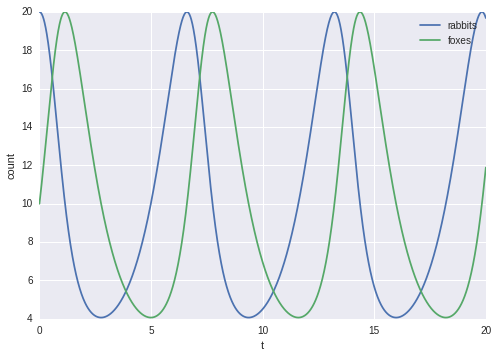

In [10]:
plt.plot(t, soln[:,0], label='rabbits')
plt.plot(t, soln[:,1], label='foxes')
plt.xlabel('t')
plt.ylabel('count')
plt.legend();

We can also make a parametric plot of $[x(t),y(t)]$:

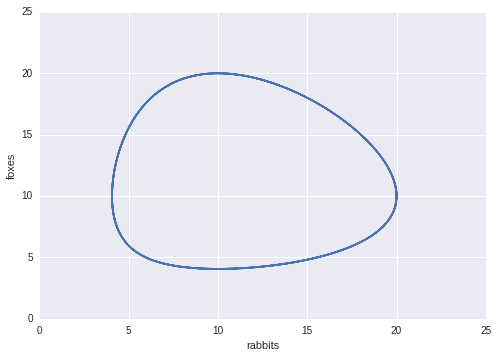

In [12]:
plt.plot(soln[:,0], soln[:,1])
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel('rabbits')
plt.ylabel('foxes');